In [1]:
import os
import sys
from google.colab import drive 
# Enlazar a la carpeta 'data'
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/ICBF/data')
sys.path.insert(0, '../scripts/0_utils')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ICBF/data


# **Modelado a partir de los datos nutricionales y sociodemográficos**

####**Descripción:**

Explora diversas opciones de modelado a partir del cruce de las tablas de datos nutricionales de tomas anteriores y las principales variables sociodemográficas identificadas y genera un modelo para predecir la reincidencia en desnutrición de un beneficiario a partir de estas variables.
 
####**Requerimientos:**

- Conjuntos serializados `auxiliary_data/IdBeneficiario_train.pickle` y `auxiliary_data/IdBeneficiario_recuperacion.pickle` de los identificadores `IdBeneficiario` de los beneficiarios de los conjuntos de entrenamiento y de aquellos que sufrieron desnutrición y se recuperaron de ella, respectivamente.
- Tablas de datos nutricionales históricos `historical_data/historico_profundidad_i.parquet`, con `i` = 1, 2, 3, indicando el número de tomas anteriores tenidas en cuenta.
- Tabla de datos `clean_data/sociodemo_beneficiario_labels.parquet` con los datos sociodemográficos y las etiquetas de cada beneficiario.
 
####**Salidas:**

- Modelos `models/model_min_soc_i.pickle`, con `i` = 1, 2, 3, que predice si un beneficiario que ha sufrido de desnutrición pero no está desnutrido en la actualidad recaerá después de 1, 2 o 3 meses, en función de sus z-scores peso/talla, peso/edad e IMC actuales e inmediatamento anteriores, y el valor de las doce variables sociodemográficas con un mayor valor de importancia.
- Listas serializada `models/model_min_soc_i_cols.pickle`, con `i` = 1, 2, 3, con las variables nutricionales y sociodemográficas utilizadas por cada modelo como predictores.

In [2]:
# Librerias relevantes 
import time
import pandas as pd
import numpy as np
import json
import re
import joblib
import random
# Modelado
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( 
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  matthews_corrcoef as mcc,
  precision_recall_curve,
  make_scorer)
# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Opciones de visualización
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
%matplotlib inline
plt.style.use('ggplot')

### **Lectura de archivos**

Como el objetivo del modelado es intentar predecir la reincidencia en desnutrición, la población base serán los beneficiarios que sufrieron desnutrición y se recuperararon de ella.

In [3]:
t0 = time.time()
# Abre la tabla de datos sociodemográficos con información del beneficiario
soc = pd.read_parquet('clean_data/sociodemo_beneficiario_labels.parquet')
# Columnas relevantes
cols_soc = joblib.load('models/model_sociodemo_cols.pickle')
# Columnas de departamento
cols_dpto = [col for col in soc.columns if 'cod_dpto' in col]
soc = soc[cols_soc + cols_dpto + ['IdBeneficiario']]
# Beneficiarios en los conjuntos de entrenamiento y prueba
IdB_train = joblib.load('auxiliary_data/IdBeneficiario_train.pickle')
IdB_test = joblib.load('auxiliary_data/IdBeneficiario_test.pickle')
# Tablas de datos nutricionales con información de las tomas anteriores
his = list()
his_test = list()
prevalencias = list()
for i in range(4):
  # Abre las tablas de datos nutricionales con información de las tomas anteriores
  tom = pd.read_parquet(f'historical_data/historico_profundidad_{i + 1}.parquet')
  # Beneficiarios que han sufrido desnutrición, pero actualmente no la sufren
  tom = tom[(tom['ZScorePesoTalla-1'] > -2) & (tom['desnutricion_previa'] > 0)]
  # Columnas relevantes
  cols_edad = [col for col in tom.columns if col[:4] == 'Edad']
  cols_medidas = [col for col in tom.columns if col[:4] == 'Peso' or col[:5] == 'Talla']
  cols_zscore = [col for col in tom.columns if col[:6] == 'ZScore']
  cols_tom = ['IdBeneficiario', 'desnutricion_previa'] + \
    sorted(cols_edad) + sorted(cols_medidas) + sorted(cols_zscore) + ['tiempo', 'desnutricion']
  tom = tom[cols_tom]
  # Cruza con la tabla de datos sociodemográficos dejando solo los registros comunes
  tom = tom[cols_tom].merge(soc, on='IdBeneficiario', how='inner')
  # Divide las tomas en conjuntos de entrenamiento y prueba
  train = tom[tom['IdBeneficiario'].isin(IdB_train)]
  test = tom[tom['IdBeneficiario'].isin(IdB_test)]
  # Prevalencia de la reincidencia
  prevalencias.append(tom['desnutricion'].mean())
  his.append(train)
  his_test.append(test)

### **Preliminares**

In [4]:
# Prevalencia promedio de la desnutrición
prevalencia = np.mean(prevalencias)
print(f"Prevalencia de la reincidencia en desnutrición: {prevalencia:.2%}.")
# Métricas a utilizar
testing_metrics = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
# Datos nulos
nulos = tom.isna().mean()
nulos[nulos > 0]

Prevalencia de la reincidencia en desnutrición: 2.70%.


Peso-2                            0.000004
Peso-3                            0.000004
Peso-4                            0.000004
Talla-2                           0.000008
Talla-3                           0.000008
Talla-4                           0.000012
ZScoreIMC-1                       0.000618
ZScoreIMC-2                       0.003178
ZScoreIMC-3                       0.005074
ZScoreIMC-4                       0.007523
ZScorePesoEdad-1                  0.000157
ZScorePesoEdad-2                  0.000552
ZScorePesoEdad-3                  0.000845
ZScorePesoEdad-4                  0.001397
ZScorePesoTalla-2                 0.001401
ZScorePesoTalla-3                 0.002519
ZScorePesoTalla-4                 0.004213
ZScoreTallaEdad-1                 0.002152
ZScoreTallaEdad-2                 0.004534
ZScoreTallaEdad-3                 0.006612
ZScoreTallaEdad-4                 0.008961
MesesLactanciaMaternaExclusiva    0.084880
MesesLactanciaMaternaTotal        0.084880
dtype: floa

### **Parámetros para la optimización de los modelos de *random forest***

Siguiendo nuestra experiencia previa registraremos las métricas utilizadas (*accuracy*, *precision*, *recall* y *f1-score*), equilibrando la *precision* y el *recall*, al intentar optimizar el *f1-score*. Por defecto, los modelos se construirán con los siguientes hiperparámetros:

- **Número de árboles (`n_estimators`)**: 150 o 200.
- **Profundidad máxima (`max_depth`)**: 5 o 10.
- **Número mínimo de muestras por hoja (`min_samples_leaf`)**: 1 ó 2.

In [5]:
# Parámetros a utilizar para la optimización de los random forest
parameters = {
  'max_depth': [5, 10],
  'min_samples_leaf': [1, 2],
  'n_estimators': [150, 200]
  }
scorers = {
  'precision_score': make_scorer(precision_score),
  'f1_score': make_scorer(f1_score),
  'mcc': make_scorer(mcc)}
def train_test_rf(df, seed=1, test_size=0.3, parameters=parameters, verbose=1):
  ''' Particiona los beneficiarios de un dataframe en conjuntos de entrenamiento y validación, 
  submuestreando las muestras de la clase mayoritaria (no desnutrición) en el conjunto de entrenamiento
  para igualar el número de muestras de la clase minoritaria. 
  Genera un random forest de clasificación a partir del conjunto de entrenamiento balanceado, 
  habiendo optimizado los hiperparámetros.
  Reporta las métricas de la clasificación del modelo en ambos conjuntos de datos y la importancia de cada variable.
  '''
  df = df.dropna()
  # Particiona los beneficiarios en conjuntos de entrenamiento y validación
  idB = list(df['IdBeneficiario'].unique())
  train_ids, test_ids = train_test_split(idB, test_size = test_size, random_state=seed)
  # Balancea el conjunto de beneficiarios en el conjunto de entrenamiento extrayendo
  # todas las muestras positivas y el mismo número de muestras negativas 
  df_train_unbalanced = df[df['IdBeneficiario'].isin(train_ids)]
  df_train_positive = df_train_unbalanced[df_train_unbalanced['desnutricion']]
  df_train_negative = df_train_unbalanced[~df_train_unbalanced['desnutricion']]
  df_train_negative_balanced = df_train_negative.sample(n = len(df_train_positive), random_state=seed)
  df_train = pd.concat([df_train_positive, df_train_negative_balanced]).sample(frac=1, random_state=seed)
  # Extrae las muestras de los beneficiarios de prueba (sin balancear)
  df_test = df[df['IdBeneficiario'].isin(test_ids)]
  # Define las variables predictoras y la variable objetivo
  X_train = df_train.drop(columns=['desnutricion', 'IdBeneficiario'])
  X_test = df_test.drop(columns=['desnutricion', 'IdBeneficiario'])
  y_train = df_train['desnutricion']
  y_test = df_test['desnutricion']
  # Realiza una búsqueda exahustiva para optimizar los hiperparámetros del random forest
  classifier = GridSearchCV(RandomForestClassifier(criterion='gini', random_state=seed), 
                            parameters, n_jobs=10, cv=5, verbose=verbose, scoring=scorers, 
                            refit='precision_score')
  # Extrae el mejor modelo y las predicciones en los conjuntos de entrenamiento y validación
  classifier.fit(X=X_train, y=y_train)
  model = classifier.best_estimator_
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  # Calcula y guarda las métricas y los hiperparámetros en un dataframe
  metrics = pd.DataFrame({
      'random_state': seed,
      'accuracy': accuracy_score(y_test, y_pred_test),
      'precision': precision_score(y_test, y_pred_test),
      'recall': recall_score(y_test, y_pred_test),
      'f1': f1_score(y_test, y_pred_test),
      'mcc': mcc(y_test, y_pred_test),
      'max_depth': classifier.best_params_['max_depth'],
      'min_samples_leaf': classifier.best_params_['min_samples_leaf'],
      'n_trees': classifier.best_params_['n_estimators']
      }, index=[seed]).round(3)
  # Calcula y guarda la importancia de cada variable predictora
  importance = pd.Series({X_train.columns[i]: model.feature_importances_[i] 
                          for i in range(len(model.feature_importances_))})
  # Retorna el modelo, las métricas y la importancia de las variables en orden decreciente
  return (model, metrics, importance.sort_values(ascending=False))

### **Modelo con información nutricional completa e información socioeconómica relevante**
#### **Variables**
De las tomas nutricionales más recientes:
- Edad (`EdadMeses`)
- Peso (`Peso`)
- Talla (`Talla`)
- z-score IMC (`ZScoreIMC`)
- z-score peso/edad (`ZScorePesoEdad`)
- z-score peso/talla (`ZScorePesoTalla`)
- z-score talla/edad (`ZScoreTallaEdad`)
- Desnutrición previa (`desnutricion_previa`)
- Las 12 variables sociodemográficas con los más altos valores de importancia
- Departamento
####**Modelos a probar**:
- **Horizonte de predicción (`tiempo`):**  1 o 3 meses.
- **Número de tomas anteriores (`tomas`):** 1 o 2 tomas anteriores.
- 5 **réplicas** por cada combinación, con el índice de la fila como semilla aleatoria.

In [6]:
# Dataframe con las características de los modelos a probar:
models_features = pd.DataFrame([[tiempo, tomas]
  for tiempo in [1, 3]
  for tomas in [1, 2]
  for replica in range(5)],
  columns=['tiempo', 'tomas'])
models_features.drop_duplicates()

tiempo  tomas
0        1      1
5        1      2
10       3      1
15       3      2

In [7]:
metrics_list = list()
importance_list = list()
parameters = {'max_depth': [10],
              'min_samples_leaf': [1],
              'n_estimators': [300]
              }
for i, features in models_features.iterrows():
  tiempo, n_tomas = features['tiempo'], features['tomas']
  df = his[n_tomas - 1]
  df = df[df['tiempo'] == tiempo].dropna()
  training = train_test_rf(df, seed=i, test_size=0.3, parameters=parameters, verbose=0)
  features = pd.DataFrame({'registros': df.shape[0],
                           'columnas': df.shape[1] - 2,
                           'tiempo': tiempo,
                           'tomas': n_tomas,
                           'tipo': 'Todas'
                           }, index = [i])
  print(f"Modelo {i}: {df.shape[1] - 2} variables, incluyendo {n_tomas} tomas anteriores para {tiempo} meses." + 
        f"Tiempo: {time.time() - t0:.2f} s.")
  model_details = pd.concat([training[1], features], axis=1)
  metrics_list.append(model_details)
  importance_list.append(training[2])
metrics_all = pd.concat(metrics_list)
importance_all = pd.concat(importance_list, axis=1).transpose()
metrics_all.groupby(['tiempo', 'tomas'])[testing_metrics].mean()

Modelo 0: 55 variables, incluyendo 1 tomas anteriores para 1 meses.Tiempo: 72.87 s.
Modelo 1: 55 variables, incluyendo 1 tomas anteriores para 1 meses.Tiempo: 80.82 s.
Modelo 2: 55 variables, incluyendo 1 tomas anteriores para 1 meses.Tiempo: 86.39 s.
Modelo 3: 55 variables, incluyendo 1 tomas anteriores para 1 meses.Tiempo: 92.07 s.
Modelo 4: 55 variables, incluyendo 1 tomas anteriores para 1 meses.Tiempo: 97.72 s.
Modelo 5: 62 variables, incluyendo 2 tomas anteriores para 1 meses.Tiempo: 104.09 s.
Modelo 6: 62 variables, incluyendo 2 tomas anteriores para 1 meses.Tiempo: 110.17 s.
Modelo 7: 62 variables, incluyendo 2 tomas anteriores para 1 meses.Tiempo: 116.21 s.
Modelo 8: 62 variables, incluyendo 2 tomas anteriores para 1 meses.Tiempo: 122.25 s.
Modelo 9: 62 variables, incluyendo 2 tomas anteriores para 1 meses.Tiempo: 128.35 s.
Modelo 10: 55 variables, incluyendo 1 tomas anteriores para 3 meses.Tiempo: 141.87 s.
Modelo 11: 55 variables, incluyendo 1 tomas anteriores para 3 meses.T

accuracy  precision  recall      f1     mcc
tiempo tomas                                             
1      1        0.7530     0.1042  0.7202  0.1820  0.2062
       2        0.7386     0.0996  0.7696  0.1762  0.2114
3      1        0.7752     0.0754  0.6844  0.1356  0.1730
       2        0.7456     0.0716  0.7336  0.1302  0.1722

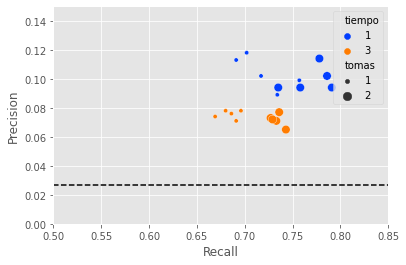

ZScorePesoTalla-1                 0.159456
ZScoreIMC-1                       0.142312
ZScorePesoTalla-2                 0.082000
ZScorePesoEdad-1                  0.081870
ZScoreIMC-2                       0.077887
ZScorePesoEdad-2                  0.058071
ZScoreTallaEdad-1                 0.040172
Peso-1                            0.039260
Talla-1                           0.031003
ZScoreTallaEdad-2                 0.030178
gasto_ppers_imp                   0.028320
ingresos_promP_imp                0.027375
Peso-2                            0.026350
EdadMeses                         0.026304
n_privaciones                     0.025975
EdadMeses-1                       0.025928
Edad_padres_mayor                 0.025774
Edad_padres_menor                 0.023987
Talla-2                           0.022604
porc_gasto_alim                   0.022242
gasto_alim_ppers_imp              0.021752
EdadMeses-2                       0.020472
Ind_nivel_sisben_4                0.019411
MesesLactan

In [8]:
# Gráfica de precision vs recall
fig = sns.scatterplot(data=metrics_all,  x='recall', y='precision',
                      hue='tiempo', size='tomas', palette='bright')
fig.set_xlim([0.5, 0.85])
fig.set_ylim([0.0, 0.15])
fig.set_xlabel('Recall')
fig.set_ylabel('Precision')
fig.axhline(prevalencia, 0, 1, color='black', linestyle="dashed")
plt.show()
# Columnas más importantes
importance_all.mean().sort_values(ascending=False)

Nuevamente, la predicción a corto plazo (1 mes) presentan mejores métricas que las de mediano plazo (3 meses). Tener en cuenta las dos últimas tomas nutricionales, en lugar de una, aumenta ligeramente los valores de *recall* sin reducir significativamente los de *precision*.

Las variables socioeconómicas y el departamento tienen valores de importancia muy bajos en comparación con las variables nutricionales.

### **Modelo mínimo nutricional e información socioeconómica relevante**
#### **Variables**
De las tomas nutricionales más recientes:
- Edad (`EdadMeses`)
- z-score peso/talla (`ZScorePesoTalla`)
- z-score IMC (`ZScoreIMC`)
- z-score peso/edad (`ZScorePesoEdad`)
- Las 12 variables sociodemográficas con los más altos valores de importancia
- Departamento

####**Modelos a probar**:
- **Horizonte de predicción (`tiempo`):**  De 1, 2, 3, 4 y 6 meses.
- **Número de tomas anteriores (`tomas`):** 1 o 2 tomas anteriores.
- 5 **réplicas** por cada combinación, con el índice de la fila como semilla aleatoria.

In [9]:
# Dataframe con las características de los modelos a probar:
models_features = pd.DataFrame([[tiempo, tomas]
  for tiempo in [1, 2, 3, 4, 6]
  for tomas in [1, 2]
  for replica in range(5)],
  columns=['tiempo', 'tomas'])
models_features.drop_duplicates()

tiempo  tomas
0        1      1
5        1      2
10       2      1
15       2      2
20       3      1
25       3      2
30       4      1
35       4      2
40       6      1
45       6      2

In [10]:
metrics_list = list()
importance_list = list()
parameters = {'max_depth': [10],
              'min_samples_leaf': [1, 2],
              'n_estimators': [300]
              }
for i, features in models_features.iterrows():
  tiempo, n_tomas = features['tiempo'], features['tomas']
  df = his[n_tomas - 1]
  cols_zscore_peso = [col for col in df.columns if col[:10] == 'ZScorePeso']
  cols_zscore_IMC = [col for col in df.columns if col[:9] == 'ZScoreIMC']
  cols_min = ['EdadMeses'] + cols_zscore_peso + cols_zscore_IMC + cols_soc
  df = df[df['tiempo'] == tiempo][['IdBeneficiario'] + cols_min + ['desnutricion']].dropna()
  training = train_test_rf(df, seed=i, test_size=0.3, parameters=parameters, verbose=0)
  features = pd.DataFrame({'registros': df.shape[0],
                           'columnas': df.shape[1] - 2,
                           'tiempo': tiempo,
                           'tomas': n_tomas,
                           'tipo': 'Mínimo'
                           }, index = [i])
  print(f"Modelo {i}: {df.shape[1] - 2} variables, incluyendo 1 toma anterior para {tiempo} meses." + 
        f"Tiempo: {time.time() - t0:.2f} s.")
  model_details = pd.concat([training[1], features], axis=1)
  metrics_list.append(model_details)
  importance_list.append(training[2])
metrics_min = pd.concat(metrics_list)
importance_min = pd.concat(importance_list, axis=1).transpose()
metrics_min.groupby(['tiempo', 'tomas'])[testing_metrics].mean()

Modelo 0: 16 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 287.59 s.
Modelo 1: 16 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 295.73 s.
Modelo 2: 16 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 303.89 s.
Modelo 3: 16 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 312.00 s.
Modelo 4: 16 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 320.08 s.
Modelo 5: 19 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 328.28 s.
Modelo 6: 19 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 336.65 s.
Modelo 7: 19 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 345.26 s.
Modelo 8: 19 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 353.67 s.
Modelo 9: 19 variables, incluyendo 1 toma anterior para 1 meses.Tiempo: 362.10 s.
Modelo 10: 16 variables, incluyendo 1 toma anterior para 2 meses.Tiempo: 371.93 s.
Modelo 11: 16 variables, incluyendo 1 toma anterior para 2 meses.Tiempo: 384.76 s.
Modelo 12: 16 

accuracy  precision  recall      f1     mcc
tiempo tomas                                             
1      1        0.7548     0.1024  0.7256  0.1794  0.2066
       2        0.7264     0.0928  0.7504  0.1650  0.1952
2      1        0.7538     0.0666  0.6288  0.1198  0.1430
       2        0.7146     0.0622  0.6834  0.1144  0.1418
3      1        0.7778     0.0742  0.6790  0.1340  0.1712
       2        0.7572     0.0748  0.7068  0.1350  0.1728
4      1        0.7212     0.0692  0.6308  0.1250  0.1370
       2        0.7046     0.0666  0.6564  0.1212  0.1364
6      1        0.6176     0.0610  0.5666  0.1092  0.0750
       2        0.5848     0.0592  0.6584  0.1084  0.0938

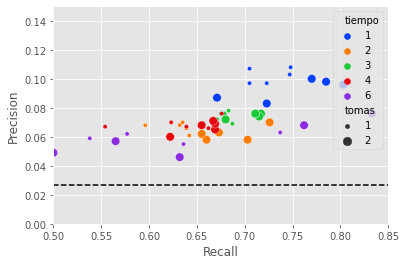

ZScorePesoTalla-1                 0.165585
ZScoreIMC-1                       0.142593
ZScorePesoEdad-1                  0.105859
ZScorePesoTalla-2                 0.091644
ZScoreIMC-2                       0.084620
ZScorePesoEdad-2                  0.083040
EdadMeses                         0.056399
gasto_ppers_imp                   0.049804
ingresos_promP_imp                0.048442
n_privaciones                     0.045737
Edad_padres_mayor                 0.043999
porc_gasto_alim                   0.041264
Edad_padres_menor                 0.041048
gasto_alim_ppers_imp              0.036867
Ind_nivel_sisben_4                0.035025
MesesLactanciaMaternaTotal        0.033324
MesesLactanciaMaternaExclusiva    0.013619
Ind_estudia                       0.008261
Ind_ninguna_discapac              0.002520
dtype: float64

In [11]:
# Gráfica de precision vs recall
fig = sns.scatterplot(data=metrics_min,  x='recall', y='precision',
                      hue='tiempo', size='tomas', palette='bright')
fig.set_xlim([0.5, 0.85])
fig.set_ylim([0.0, 0.15])
fig.set_xlabel('Recall')
fig.set_ylabel('Precision')
fig.axhline(prevalencia, 0, 1, color='black', linestyle="dashed")
plt.show()
# Columnas más importantes
importance_min.mean().sort_values(ascending=False)

### **Modelos finales, curva *precision-recall* y distribución de *p-scores***
Los modelos finales se construyen a partir de las dos últimas tomas nutricionales de cada beneficiario y los datos sociodemográficos (12 variables, con la información del departamento), utilizando todos los datos de entrenamiento y se ampliará el conjunto de parámetros para realizar la búsqueda.

Los modelos intentarán predecir la recurrencia en desnutrición uno y tres meses después de la última valoración nutricional. Ambos modelos se evalúan en los beneficiarios del conjunto de prueba.

Modelo 'model_min_soc_1.pickle' guardado: 1156.81 s.


random_state  accuracy  precision  recall     f1    mcc  max_depth  \
1            12     0.748      0.096   0.791  0.172  0.216          6   

   min_samples_leaf  n_trees  
1                 2      150

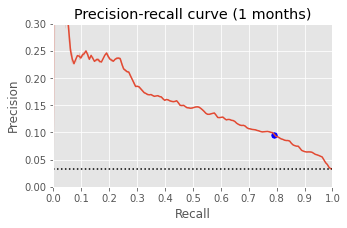

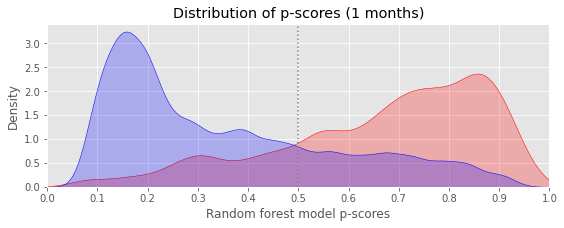

Modelo 'model_min_soc_2.pickle' guardado: 1559.25 s.


random_state  accuracy  precision  recall     f1    mcc  max_depth  \
2            12     0.708      0.071   0.766  0.131  0.171         10   

   min_samples_leaf  n_trees  
2                 1      200

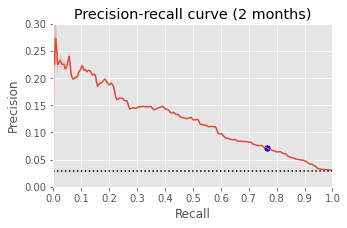

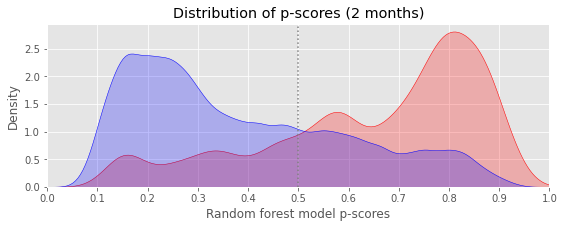

Modelo 'model_min_soc_3.pickle' guardado: 2495.12 s.


random_state  accuracy  precision  recall    f1   mcc  max_depth  \
3            12     0.749      0.065    0.71  0.12  0.16         20   

   min_samples_leaf  n_trees  
3                 4      250

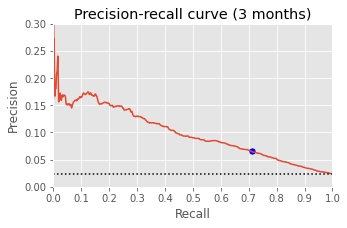

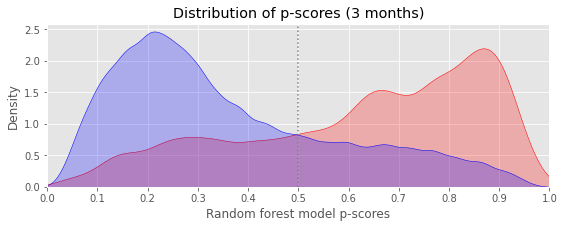

In [12]:
# Modelo mínimo, con variables sociodemográficas más relevantes
model_min = dict()
seed = 12
n_tomas = 2
parameters = {'max_depth': [2 * (i + 1) for i in range(10)],
              'min_samples_leaf': [1, 2, 3, 4],
              'n_estimators': [150, 200, 250]
              }
for tiempo in [1, 2, 3]:
  # Toma todo el conjunto de datos de entrenamiento
  df = his[n_tomas - 1]
  cols_zscore_peso = [col for col in df.columns if col[:10] == 'ZScorePeso']
  cols_zscore_IMC = [col for col in df.columns if col[:9] == 'ZScoreIMC']
  cols_min = ['EdadMeses'] + cols_zscore_peso + cols_zscore_IMC + cols_soc 
  df_train_unbalanced = df.loc[df['tiempo'] == tiempo, 
                               ['IdBeneficiario'] + cols_min + ['desnutricion']].\
                               dropna()
  # Balancea el conjunto de beneficiarios en el conjunto de entrenamiento extrayendo
  # todas las muestras positivas y el mismo número de muestras negativas 
  #df_train_unbalanced = df[df['IdBeneficiario'].isin(train_ids)]
  df_train_positive = df_train_unbalanced[df_train_unbalanced['desnutricion']]
  df_train_negative = df_train_unbalanced[~df_train_unbalanced['desnutricion']]
  df_train_negative_balanced = df_train_negative.sample(n = len(df_train_positive), random_state=seed)
  df_train = pd.concat([df_train_positive, df_train_negative_balanced]).sample(frac=1, random_state=seed)
  # Extrae las muestras de los beneficiarios de prueba (sin balancear)
  df_test = his_test[n_tomas - 1]
  df_test = df_test.loc[df_test['tiempo'] == tiempo, ['IdBeneficiario'] + cols_min + ['desnutricion']].\
    dropna()
  # Define las variables predictoras y la variable objetivo
  X_train = df_train.drop(columns=['desnutricion', 'IdBeneficiario'])
  X_test = df_test.drop(columns=['desnutricion', 'IdBeneficiario'])
  y_train = df_train['desnutricion']
  y_test = df_test['desnutricion']
  # Realiza una búsqueda exahustiva para optimizar los hiperparámetros del random forest
  classifier = GridSearchCV(RandomForestClassifier(criterion='gini', random_state=seed), 
                            parameters, n_jobs=10, cv=5, verbose=0, scoring=scorers, 
                            refit='f1_score')
  # Extrae el mejor modelo y las predicciones en los conjuntos de entrenamiento y validación
  classifier.fit(X=X_train, y=y_train)
  model_min = classifier.best_estimator_
  y_pred_train = model_min.predict(X_train)
  y_pred_test = model_min.predict(X_test)
  # Probabilidades (p-scores) asociadas a cada beneficiario en el conjunto de prueba
  p_scores = [q for p, q in model_min.predict_proba(X_test)]
  # Calcula y guarda las métricas y los hiperparámetros en un dataframe
  metrics = pd.DataFrame({
      'random_state': seed,
      'accuracy': accuracy_score(y_test, y_pred_test),
      'precision': precision_score(y_test, y_pred_test),
      'recall': recall_score(y_test, y_pred_test),
      'f1': f1_score(y_test, y_pred_test),
      'mcc': mcc(y_test, y_pred_test),
      'max_depth': classifier.best_params_['max_depth'],
      'min_samples_leaf': classifier.best_params_['min_samples_leaf'],
      'n_trees': classifier.best_params_['n_estimators']
      }, index=[tiempo]).round(3)
  # Guarda la lista de variables y el modelo para su implementación
  joblib.dump(model_min, f'models/model_min_soc_{tiempo}.pickle')
  joblib.dump(list(X_train.columns), f'models/model_min_soc_{tiempo}_cols.pickle')
  print(f"Modelo 'model_min_soc_{tiempo}.pickle' guardado: {time.time() - t0:.2f} s.")
  display(metrics)
  # Grafica la curva precision-recall
  plt.rcParams["figure.figsize"] = (5, 3)
  precision, recall, thresholds = precision_recall_curve(y_test, p_scores)
  fig = sns.lineplot(x=recall, y=precision, palette='Reds')
  fig = sns.scatterplot(data=metrics, x='recall', y='precision', s=50, color='blue')
  fig.set_title(f"Precision-recall curve ({tiempo} months)")
  fig.set_xticks([0.1 * i for i in range(11)])
  fig.set_yticks([0.05 * i for i in range(21)])
  fig.set_xlim([0, 1])
  fig.set_ylim([0, 0.3])
  fig.set_xlabel('Recall')
  fig.set_ylabel('Precision')
  fig.axhline(y_test.mean(), 0, 1, color='black', linestyle="dotted", linewidth=1.5)
  plt.show()
  # Grafica la distribución de p-scores por cada clase
  distribution = pd.DataFrame({'p_scores': p_scores,
                               'y_test': y_test})
  plt.rcParams["figure.figsize"] = (9, 3)
  # Densidad de cada distribución
  fig = sns.kdeplot(distribution[distribution['y_test']]['p_scores'],
                    shade=True, color="red", clip=[0, 1], bw_adjust=0.5)
  fig = sns.kdeplot(distribution[~distribution['y_test']]['p_scores'],
                    shade=True, color="blue", clip=[0, 1], bw_adjust=0.5)
  fig.set_xticks([0.1 * i for i in range(11)])
  fig.axvline(0.5, 0, 10, color='grey', linestyle="dotted", linewidth=1.5)
  fig.set_xlim([0, 1])
  fig.set_title(f"Distribution of p-scores ({tiempo} months)")
  fig.set_xlabel('Random forest model p-scores')
  fig.set_ylabel('Density')
  plt.show()